## To discuss the clustering of deformation pattern

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from natsort import natsort
from sklearn.cluster import KMeans
import pandas as pd
from matplotlib.colors import ListedColormap

In [16]:
def make_particle_change_lists(change_lists_array, num_list=False):
    particel_num_lists_1d_array = np.asarray([np.hsplit(change_lists_array[num],[1])[0] 
                            for num in range(len(change_lists_array))],dtype=object)
        
    change_lists_1d_array = np.asarray([np.hsplit(change_lists_array[num],[1])[1] 
                            for num in range(len(change_lists_array))],dtype=object)
    
        ## remove  nan and inf value
    change_lists_1d_array_mod = np.asarray([np.nan_to_num(change_lists_1d_array[num],nan=0.0, posinf=0.0, neginf=0.0) 
                                        for num in range(len(change_lists_1d_array))],dtype=object)
    result_lists = []
    
    if num_list == False:
        for i in tqdm(np.unique(particel_num_lists_1d_array[0])):
            change_rate_lists = []
            for j in range(len(change_lists_1d_array)):
                change_list_1d_array = change_lists_1d_array_mod[j]
                change_rate = change_list_1d_array[np.where(particel_num_lists_1d_array[j]==i)[0]]
                if change_rate.size==0:
                    continue
                else:
                    change_rate_lists.extend(change_rate)
            result_lists.append(change_rate_lists)
    
    if num_list == True:
        num_list_and_particle_change_rate_lists = []
        for i in tqdm(np.unique(particel_num_lists_1d_array[0])):
            change_rate_lists = []
            for j in range(len(change_lists_1d_array)):
                change_list_1d_array = change_lists_1d_array_mod[j]
                change_rate = change_list_1d_array[np.where(particel_num_lists_1d_array[j]==i)[0]]
                if change_rate.size==0:
                    continue
                else:   
                    change_rate_lists.extend(change_rate)
            
            insert = np.zeros(len(change_lists_array))
            insert[:len(change_rate_lists)] = change_rate_lists
            change_rate_lists = insert
            change_rate_lists_2 = np.append(i, change_rate_lists)
            result_lists.append(change_rate_lists_2)

        
    return result_lists



def modify_change_lists(result_lists, max_num, min_num):
    selected_lists = []
    original_p_n_lists = []
    modified_p_n_lists = []
    for i in tqdm(range(len(result_lists))):
        result_list = result_lists[i]
        if np.max(result_list[1:])> max_num or np.min(result_list[1:]) < min_num:
            original_p_n_lists.append(result_list[0])
            modified_p_n_lists.append(0)
        else:
            selected_lists.append(result_list)
            original_p_n_lists.append(result_list[0])
            modified_p_n_lists.append(result_list[0])
            
    return selected_lists, original_p_n_lists, modified_p_n_lists

In [3]:
def modify_nuclei_true(nuclei_list, original_p_n_lists, modified_p_n_lists):
    #set 3D storage
    result_map = np.zeros((nuclei_list[:,:,0].shape[0], nuclei_list[:,:,0].shape[1]))
        
    #set zero map
    zero_map=np.zeros((nuclei_list[:,:,0].shape[0]*nuclei_list[:,:,0].shape[1]))    

    #set target
    target_nuclei=list(nuclei_list[:,:,-1].flatten())
    
    #set function
    replace_func = {new: k_label for new, k_label in zip(original_p_n_lists, modified_p_n_lists)} 

    #replace label values to anatomical values
    replace_result=np.asarray(list(map(replace_func.get, target_nuclei)))
    result_index=np.where(replace_result!=None)[0]

    #project the result to zero map
    zero_map[result_index]=replace_result[result_index]

    #save result
    result_map[:,:]=zero_map.reshape((nuclei_list[:,:,0].shape[0], nuclei_list[:,:,0].shape[1]))
        
    return result_map

In [4]:
def result_visualization_kmeans(nuclei_list, kmeans_results):
    #set 3D storage
    result_map = np.zeros((nuclei_list[:,:].shape[0], nuclei_list[:,:].shape[1]))
    
    label=np.unique(nuclei_list[:,:])[1:]
    target_nuclei=list(nuclei_list[:,:].flatten())
        
    #set zero map
    zero_map=np.zeros((nuclei_list[:,:].shape[0]*nuclei_list[:,:].shape[1]))    

    #set function
    replace_func = {new: k_label for new, k_label in zip(label, kmeans_results)} 

    #replace label values to anatomical values
    replace_result=np.asarray(list(map(replace_func.get, target_nuclei)))
    result_index=np.where(replace_result!=None)[0]

    #project the result to zero map
    zero_map[result_index]=replace_result[result_index]

    #save result
    result_map[:,:]=zero_map.reshape((nuclei_list[:,:].shape[0], nuclei_list[:,:].shape[1]))
        
    return result_map

In [5]:
def kmeans_map_and_distribution(nuclei_true, lists_array, num_for_normalized_start_point, threshold_max, threshold_min, num_clusters):
    num = num_for_normalized_start_point
    
    first_list = []
    for j in range(len(lists_array[0])):
        average_value = np.average([lists_array[k][j][1:2].astype('float') for k in range(num)])
        average_num = np.average([lists_array[k][j][0:1].astype('float') for k in range(num)])
        average = np.asarray([average_num, average_value])
        first_list.append(average)
    target_list_all = np.vstack((np.expand_dims(first_list, axis=0),lists_array[num:]))
    
    change_lists_mod = []
    for i in tqdm(range(len(target_list_all))):
        first_list = target_list_all[0]
        target_list = target_list_all[i]
        selected_list = first_list[np.where(first_list[:,:1]==np.intersect1d(first_list[:,:1], target_list[:,:1]))[0]]
        change_rate = ((target_list[:,1:2] - selected_list[:,1:2])/selected_list[:,1:2])*100
        change_list = np.stack((target_list[:,:1][:,0], change_rate[:,0]), axis=-1)
        change_lists_mod.append(change_list)
        
    df_array = make_particle_change_lists(change_lists_mod, num_list=True)
    df_array = np.nan_to_num(df_array, nan=0.0, posinf=0.0, neginf=0.0)
    df_array_mod, original_p_n_lists, modified_p_n_lists = modify_change_lists(df_array, threshold_max, threshold_min)
    df_mod = pd.DataFrame(df_array_mod)
    
    num_clusters = num_clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    model = kmeans.fit(df_mod.iloc[:,1:])
    kmeans_result = model.predict(df_mod.iloc[:,1:])
    
    nuclei_true_mod = modify_nuclei_true(nuclei_true, original_p_n_lists, modified_p_n_lists)
    kmeans_map = result_visualization_kmeans(nuclei_true_mod, kmeans_result)
    
    colors = ["gray", "blue", "green", "purple", "orange", "pink", "aqua","red"]
    
    def sort_colorlist(c_order,colorlist):
        clist = ['a']*len(colorlist)
        for k in range(len(clist)):
            clist[c_order[k]]= colorlist[k]
        return clist

    interval = np.arange(-.5,8,1)
    order, _=np.histogram(kmeans_result, bins=num_clusters)
    c_order=np.argsort(order)[::-1]
    adj_colorlist=sort_colorlist(c_order,colors)
    cmap = ListedColormap(adj_colorlist, name="custom")
    cmap.set_bad("black")
    cm = cmap

    fig, ax = plt.subplots(1,3,figsize=(20,6))

    ax[0].pcolormesh(np.ma.array(kmeans_map[:,:], mask=nuclei_true_mod[:,:]==0), cmap = cm)
    ax[0].axis('off')
    ax[0].set_title('clustered image', fontsize=14)
    ax[0].set_aspect('equal')
    ax[0].invert_yaxis()

    for i in range(len(kmeans.cluster_centers_)):
        ax[1].plot(kmeans.cluster_centers_[i],c=adj_colorlist[i],linewidth=3)
    ax[1].set_title('Centor', fontsize=14)
    ax[1].set_xlabel('Strain', fontsize=14)

    #
    n, bins, patches = ax[2].hist(kmeans_result, bins=interval, rwidth=0.6, density=True)
    for i in range(num_clusters):
        patches[i].set_facecolor(adj_colorlist[i])
    ax[2].set_title('population in image', fontsize=14)
    ax[2].set_xlabel('cluster number',fontsize=14)

    fig.tight_layout()
    # plt.show()

### Test

In [6]:
HF_list = np.load('./seg_results/HF-4_common.npz',allow_pickle=True)
HF_map = np.load('./seg_results/HF-4_map_common.npz') 

In [7]:
HF_list.files

['area',
 'ecc',
 'cir',
 'major',
 'minor',
 'aspect_axis',
 'vert',
 'hori',
 'aspect_bbox',
 'feret',
 'area_change',
 'ecc_change',
 'cir_change',
 'major_change',
 'minor_change',
 'aspect_axis_change',
 'vert_change',
 'hori_change',
 'aspect_bbox_change',
 'feret_change']

In [8]:
#track_result_filtered = pd.read_pickle("./seg_results/HR-1_filtered.pkl")
nuclei_true = HF_map['nuclei']
lists_array = HF_list['area']

In [9]:
change_lists_mod = []

num = 5
first_list = []

for j in range(len(lists_array[0])):
    average_value = np.average([lists_array[k][j][1:2].astype('float') for k in range(num)])
    average_num = np.average([lists_array[k][j][0:1].astype('float') for k in range(num)])
    average = np.asarray([average_num, average_value])
    first_list.append(average)

target_list_all = np.vstack((np.expand_dims(first_list, axis=0),lists_array[num:]))

for i in tqdm(range(len(target_list_all))):
    first_list = target_list_all[0]
    target_list = target_list_all[i]
    selected_list = first_list[np.where(first_list[:,:1]==np.intersect1d(first_list[:,:1], target_list[:,:1]))[0]]
    change_rate = ((target_list[:,1:2] - selected_list[:,1:2])/selected_list[:,1:2])*100
    change_list = np.stack((target_list[:,:1][:,0], change_rate[:,0]), axis=-1)
    change_lists_mod.append(change_list)

100%|███████████████████████████████████████████| 84/84 [00:35<00:00,  2.37it/s]


In [12]:
df_change_lists = make_particle_change_lists(change_lists_mod, num_list=True)

100%|██████████████████████████████████████| 5083/5083 [00:22<00:00, 230.80it/s]


In [17]:
selected_lists, original_p_n_lists, modified_p_n_lists = modify_change_lists(df_change_lists, 35, -35)

100%|███████████████████████████████████| 5083/5083 [00:00<00:00, 133801.40it/s]


In [18]:
np.unique(selected_lists)

array([  -34.7826087 ,   -34.18803419,   -33.1797235 , ...,
       14248.        , 14264.        , 14276.        ])

In [19]:
nuclei_true_mod = modify_nuclei_true(nuclei_true, original_p_n_lists, modified_p_n_lists)

In [20]:
df_mod = pd.DataFrame(selected_lists)
df_mod.iloc[:,1:]

,1,2,3,4,5,6,7,8,9,10,...,75,76,77,78,79,80,81,82,83,84
0,0.0,-2.484940,3.539157,-0.602410,-0.602410,2.033133,-0.602410,-0.978916,-0.225904,2.786145,...,2.033133,-1.355422,0.150602,2.033133,-2.484940,3.915663,0.903614,1.656627,0.150602,0.527108
1,0.0,0.758853,-1.770658,-3.456998,-0.505902,-1.349073,2.023609,-4.300169,-1.349073,-0.927487,...,-2.192243,1.180438,0.337268,-0.084317,2.023609,0.758853,-1.770658,-2.192243,-0.927487,0.337268
2,0.0,-0.197628,-0.691700,-0.691700,-2.173913,2.272727,-5.138340,1.778656,0.790514,-4.150198,...,1.284585,2.272727,0.296443,0.296443,-1.185771,-2.173913,3.754941,-3.162055,0.296443,-2.173913
3,0.0,-13.793103,-11.050157,-0.470219,-7.523511,-4.388715,2.664577,7.366771,-7.523511,-9.874608,...,-11.442006,-8.307210,-14.184953,-7.523511,-10.266458,-8.699060,-11.833856,-7.915361,-8.699060,-8.699060
4,0.0,0.171233,2.311644,1.455479,-2.825342,-1.969178,1.455479,0.171233,1.455479,1.883562,...,2.311644,2.311644,2.739726,2.311644,5.308219,0.599315,1.883562,2.739726,2.311644,2.739726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5017,0.0,1.683938,2.331606,4.274611,6.865285,13.989637,13.989637,2.979275,4.274611,5.569948,...,7.512953,2.979275,1.683938,-1.554404,8.160622,9.455959,0.388601,-7.383420,1.683938,0.388601
5018,0.0,5.988024,1.796407,3.592814,3.592814,4.790419,2.395210,2.395210,-0.598802,1.796407,...,0.000000,-4.790419,-5.389222,4.191617,7.185629,0.000000,-2.994012,1.197605,0.000000,-2.994012
5019,0.0,-12.000000,-10.000000,-4.000000,24.000000,-14.000000,18.000000,-8.000000,-4.000000,12.000000,...,4.000000,10.000000,8.000000,10.000000,16.000000,10.000000,22.000000,8.000000,4.000000,14.000000
5020,0.0,3.104213,6.430155,5.321508,1.995565,1.995565,-1.330377,0.886918,3.104213,-1.330377,...,-10.199557,-3.547672,4.212860,-11.308204,-12.416851,-6.873614,-7.982262,-4.656319,-10.199557,-2.439024


In [21]:
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
model = kmeans.fit(df_mod.iloc[:,1:])
kmeans_result = model.predict(df_mod.iloc[:,1:])

In [22]:
HF_kmeans_map = result_visualization_kmeans(nuclei_true_mod, kmeans_result)

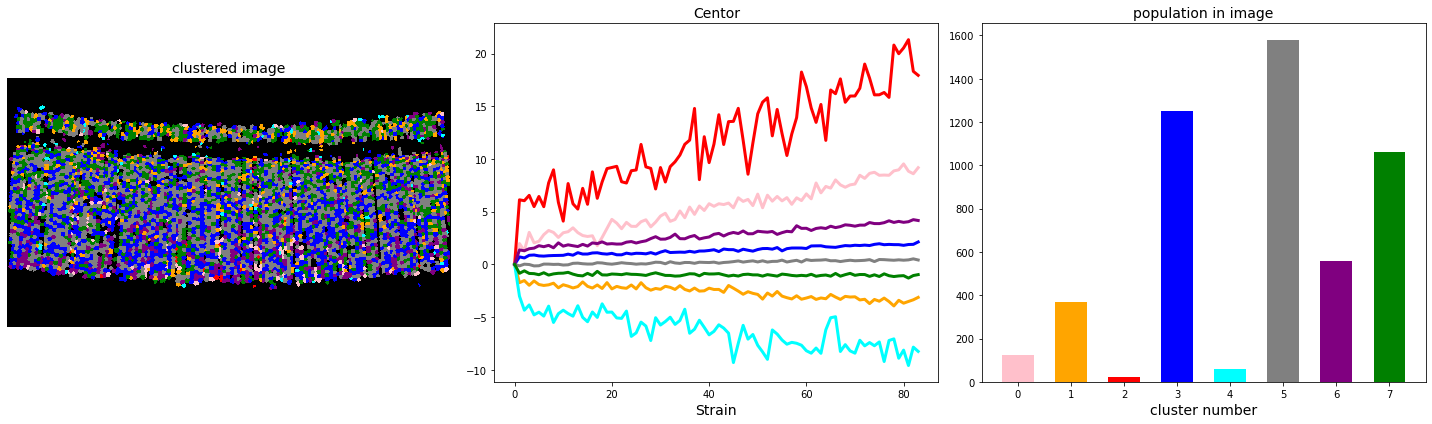

In [24]:
from matplotlib.colors import ListedColormap

colors = ["gray", "blue", "green", "purple", "orange", "pink", "aqua","red"]
def sort_colorlist(c_order,colorlist):
    clist = ['a']*len(colorlist)
    for k in range(len(clist)):
        clist[c_order[k]]= colorlist[k]
    return clist

interval = np.arange(-.5,8,1)
order, _=np.histogram(kmeans_result, bins=num_clusters)
c_order=np.argsort(order)[::-1]
adj_colorlist=sort_colorlist(c_order,colors)

cmap = ListedColormap(adj_colorlist, name="custom")
cmap.set_bad("black")
cm= cmap

fig, ax = plt.subplots(1,3,figsize=(20,6))

ax[0].pcolormesh(np.ma.array(HF_kmeans_map[:,:], mask=nuclei_true_mod[:,:]==0), cmap = cm)
ax[0].axis('off')
ax[0].set_title('clustered image', fontsize=14)
ax[0].set_aspect('equal')
ax[0].invert_yaxis()

for i in range(len(kmeans.cluster_centers_)):
    ax[1].plot(kmeans.cluster_centers_[i],c=adj_colorlist[i],linewidth=3)
ax[1].set_title('Centor', fontsize=14)
ax[1].set_xlabel('Strain', fontsize=14)

#
n, bins, patches = ax[2].hist(kmeans_result, bins=interval, rwidth=0.6)
for i in range(num_clusters):
    patches[i].set_facecolor(adj_colorlist[i])
ax[2].set_title('population in image', fontsize=14)
ax[2].set_xlabel('cluster number',fontsize=14)

fig.tight_layout()
# plt.show()

### HR-1

In [25]:
HR_list = np.load('./seg_results/HR-1_common.npz',allow_pickle=True)
HR_map = np.load('./seg_results/HR-1_map_common.npz') 

100%|███████████████████████████████████| 5272/5272 [00:00<00:00, 169955.27it/s]


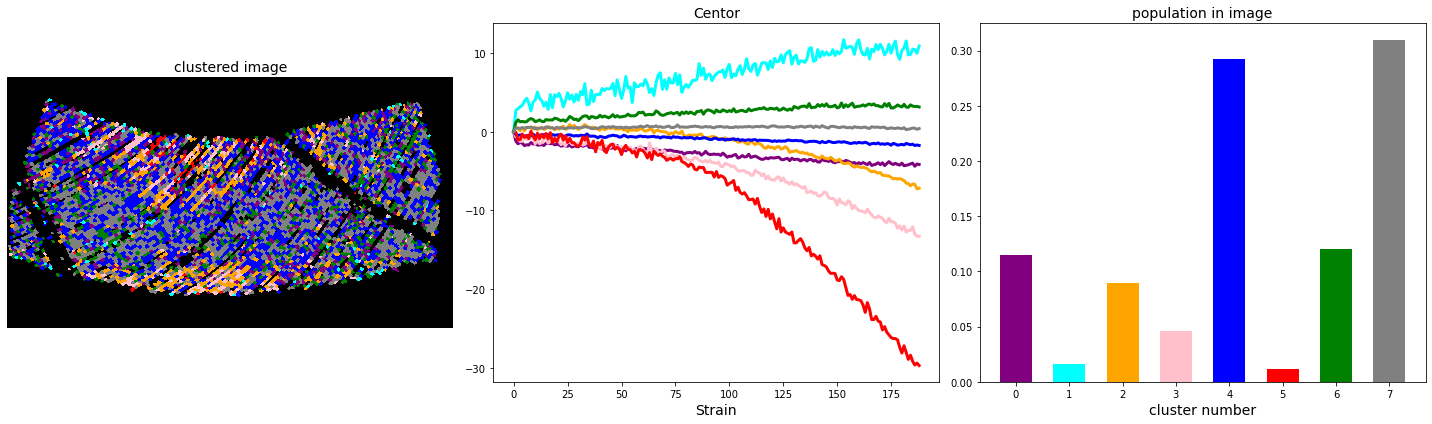

In [26]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['area']
kmeans_map_and_distribution(nuclei_true, lists_array, 5, 50,-50, 8)

100%|███████████████████████████████████| 5272/5272 [00:00<00:00, 182044.26it/s]


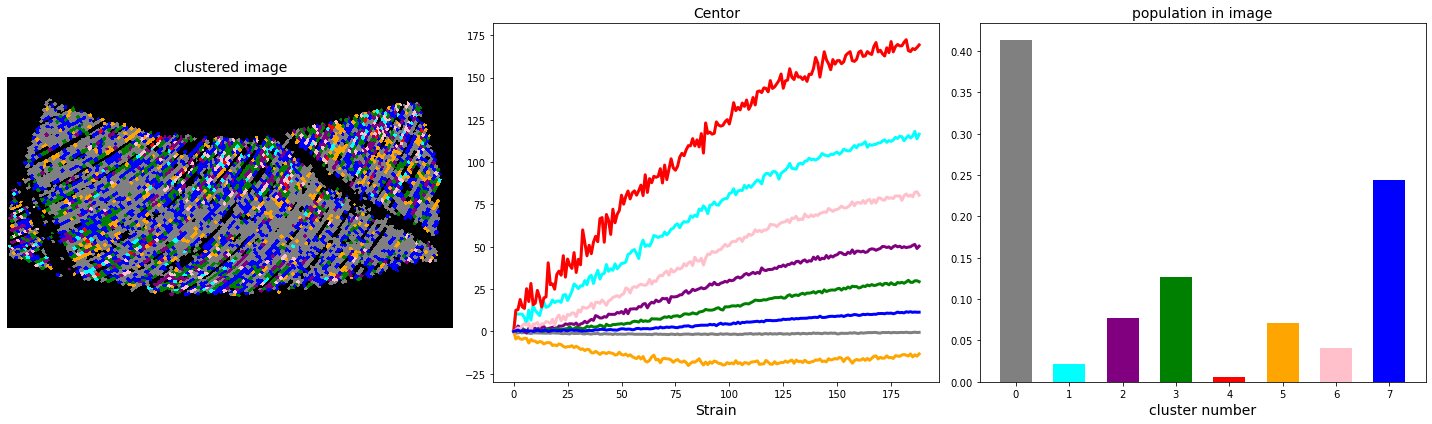

In [31]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['ecc']

kmeans_map_and_distribution(nuclei_true, lists_array, 5, 1000, -1000, 8)

100%|███████████████████████████████████| 5272/5272 [00:00<00:00, 305373.09it/s]


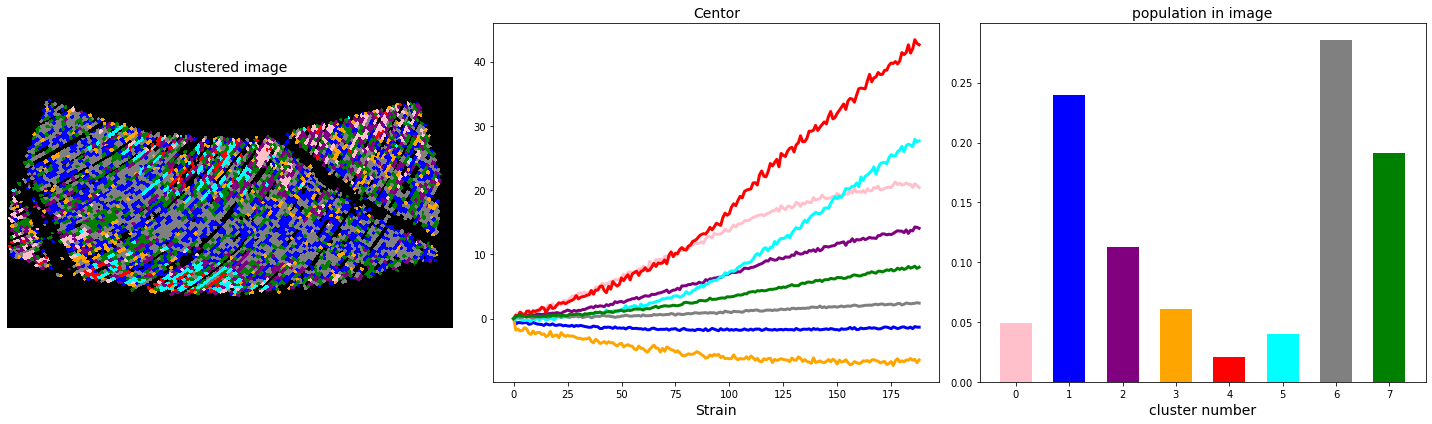

In [109]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['aspect_axis']

kmeans_map_and_distribution(nuclei_true, lists_array, 5, 1000, -1000, 8)

100%|███████████████████████████████████| 5272/5272 [00:00<00:00, 177097.31it/s]


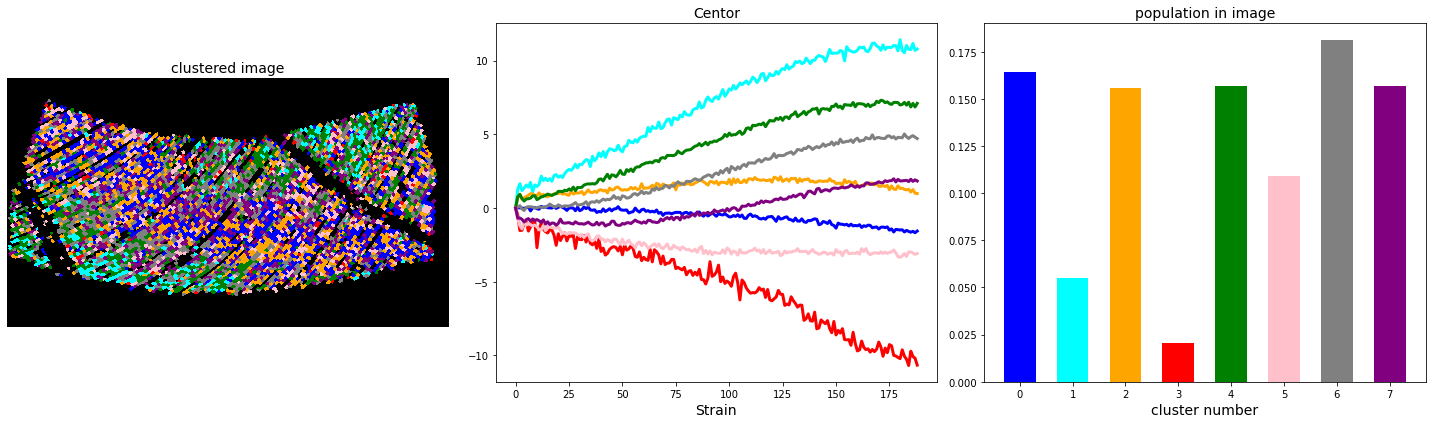

In [32]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['feret']

kmeans_map_and_distribution(nuclei_true, lists_array, 5, 50,-50, 8)

100%|███████████████████████████████████| 5272/5272 [00:00<00:00, 180826.52it/s]


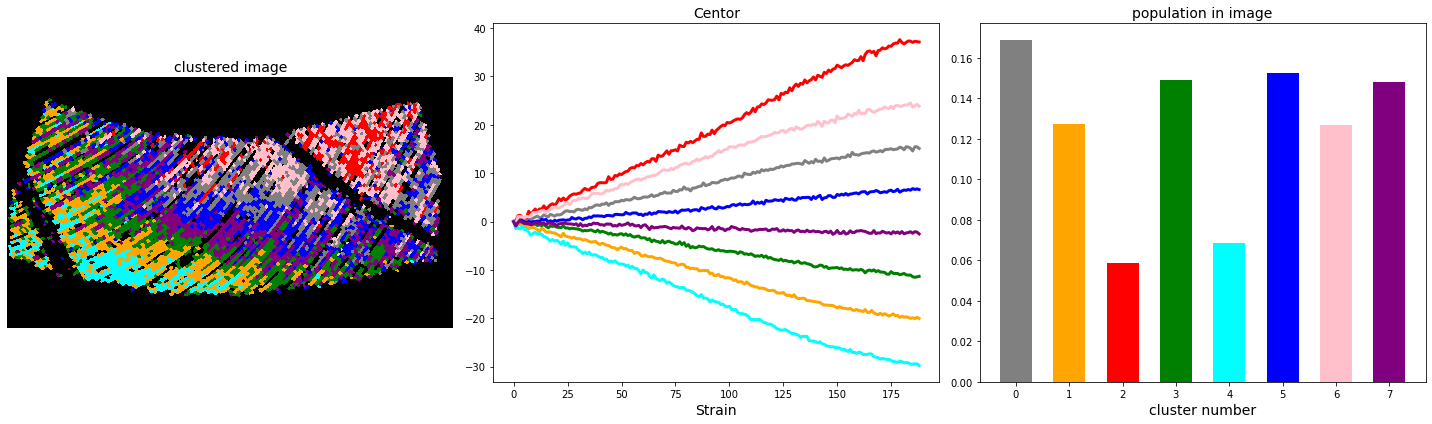

In [33]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['aspect_bbox']

kmeans_map_and_distribution(nuclei_true, lists_array, 5, 1000, -1000, 8)

### r-H-5

In [34]:
HR_list = np.load('./seg_results/r-H-5_common.npz',allow_pickle=True)
HR_map = np.load('./seg_results/r-H-5_map_common.npz') 

In [35]:
HR_list.files

['area',
 'ecc',
 'cir',
 'major',
 'minor',
 'aspect_axis',
 'vert',
 'hori',
 'aspect_bbox',
 'feret',
 'area_change',
 'ecc_change',
 'cir_change',
 'major_change',
 'minor_change',
 'aspect_axis_change',
 'vert_change',
 'hori_change',
 'aspect_bbox_change',
 'feret_change']

100%|███████████████████████████████████| 5220/5220 [00:00<00:00, 179368.58it/s]


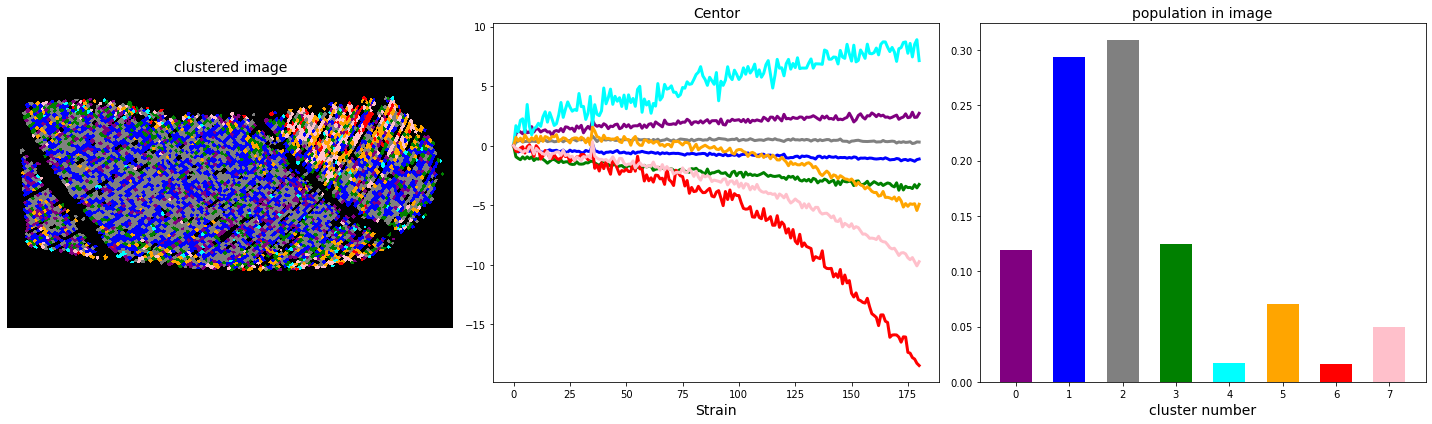

In [36]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['area']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 35, -35, 8)

100%|███████████████████████████████████| 5220/5220 [00:00<00:00, 181684.61it/s]


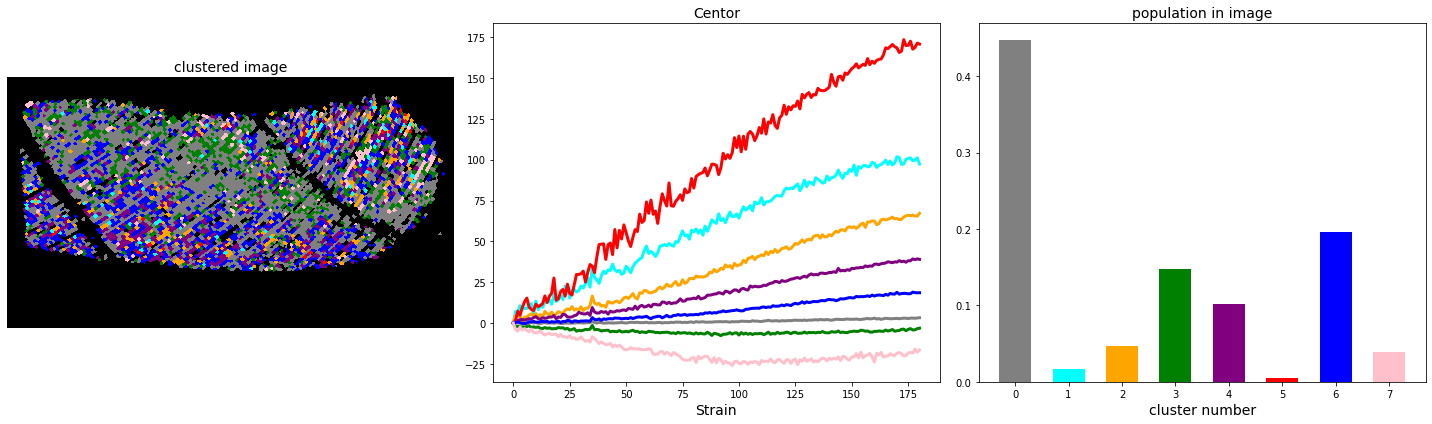

In [37]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['ecc']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 1000,-1000, 8)

100%|███████████████████████████████████| 5220/5220 [00:00<00:00, 190100.61it/s]


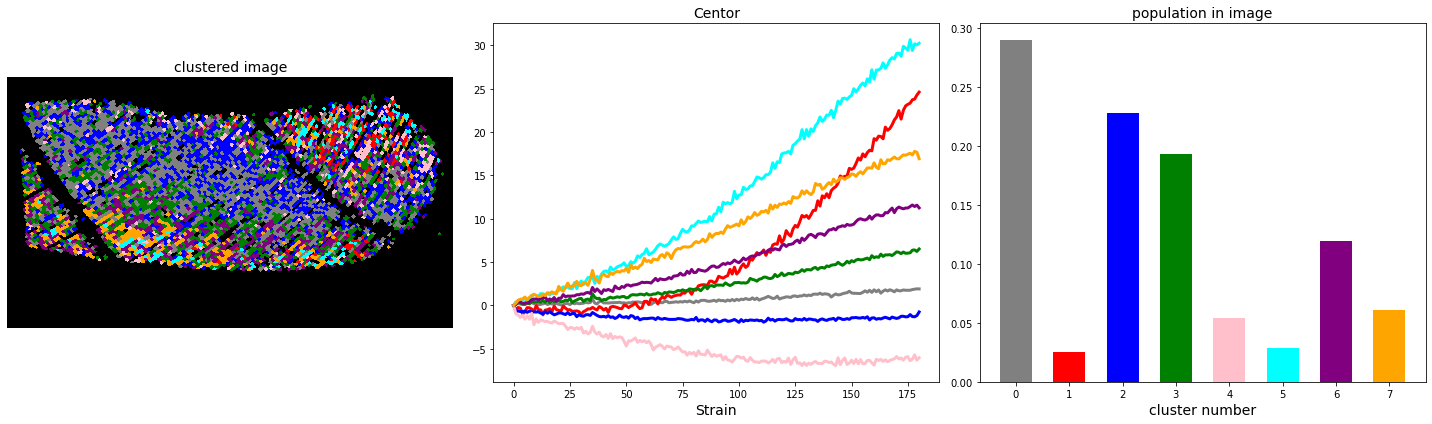

In [38]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['aspect_axis']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 50,-50, 8)

100%|███████████████████████████████████| 5220/5220 [00:00<00:00, 190887.88it/s]


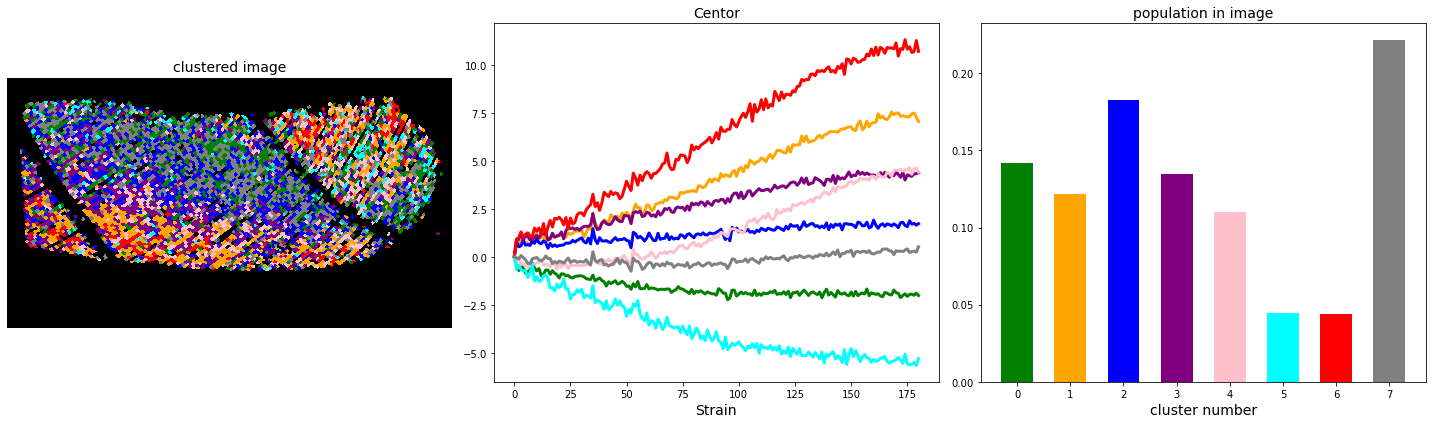

In [39]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['feret']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 30,-30, 8)

100%|███████████████████████████████████| 5220/5220 [00:00<00:00, 184955.29it/s]


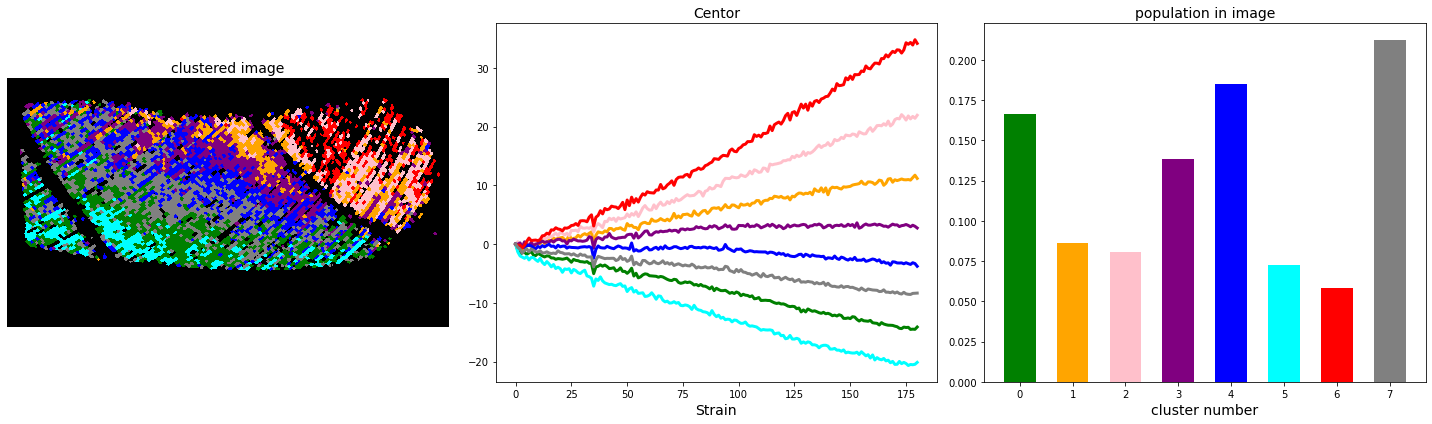

In [40]:
nuclei_true = HR_map['nuclei']
lists_array = HR_list['aspect_bbox']

kmeans_map_and_distribution(nuclei_true, lists_array, 12, 50,-50, 8)

### HF-4

In [41]:
HF_list = np.load('./seg_results/HF-4_common.npz',allow_pickle=True)
HF_map = np.load('./seg_results/HF-4_map_common.npz') 

In [42]:
HF_list.files

['area',
 'ecc',
 'cir',
 'major',
 'minor',
 'aspect_axis',
 'vert',
 'hori',
 'aspect_bbox',
 'feret',
 'area_change',
 'ecc_change',
 'cir_change',
 'major_change',
 'minor_change',
 'aspect_axis_change',
 'vert_change',
 'hori_change',
 'aspect_bbox_change',
 'feret_change']

100%|███████████████████████████████████| 5083/5083 [00:00<00:00, 180685.70it/s]


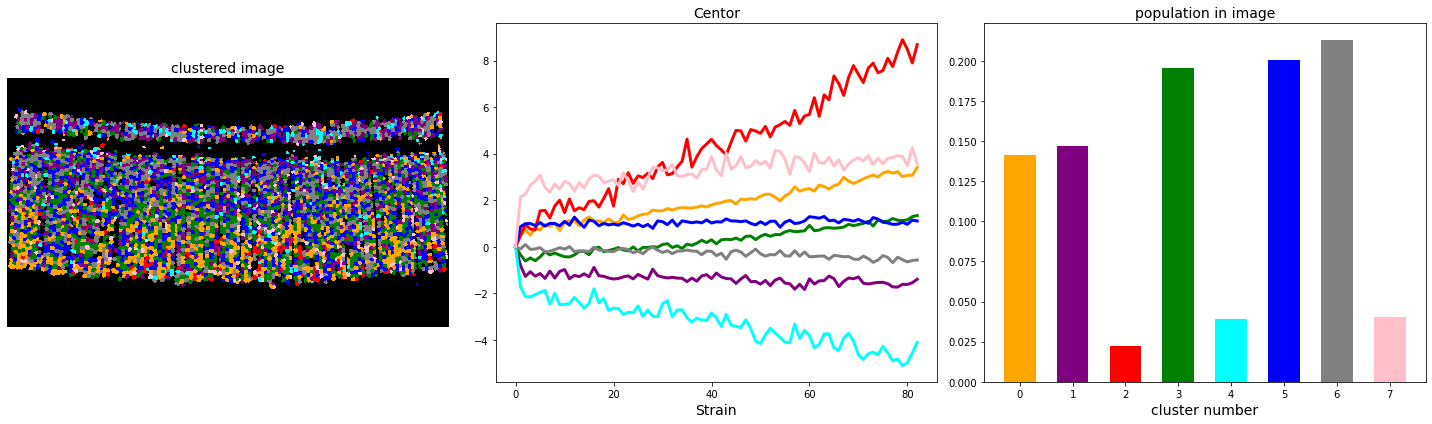

In [43]:
nuclei_true = HF_map['nuclei']
lists_array = HF_list['area']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 20,-20, 8)

100%|███████████████████████████████████| 5083/5083 [00:00<00:00, 188684.47it/s]


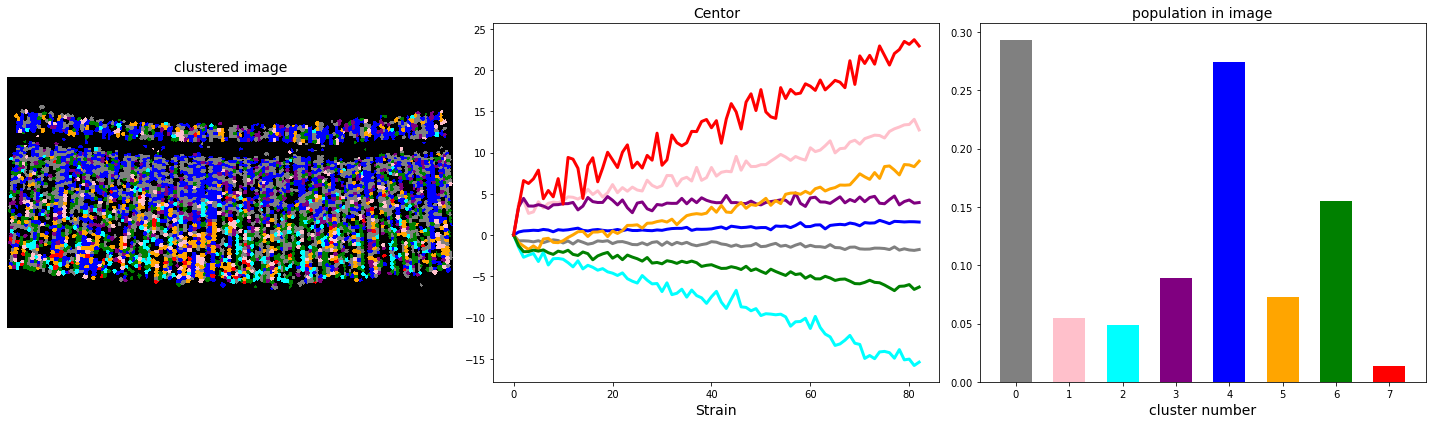

In [47]:
nuclei_true = HF_map['nuclei']
lists_array = HF_list['ecc']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 40,-40, 8)

100%|███████████████████████████████████| 5083/5083 [00:00<00:00, 175101.41it/s]


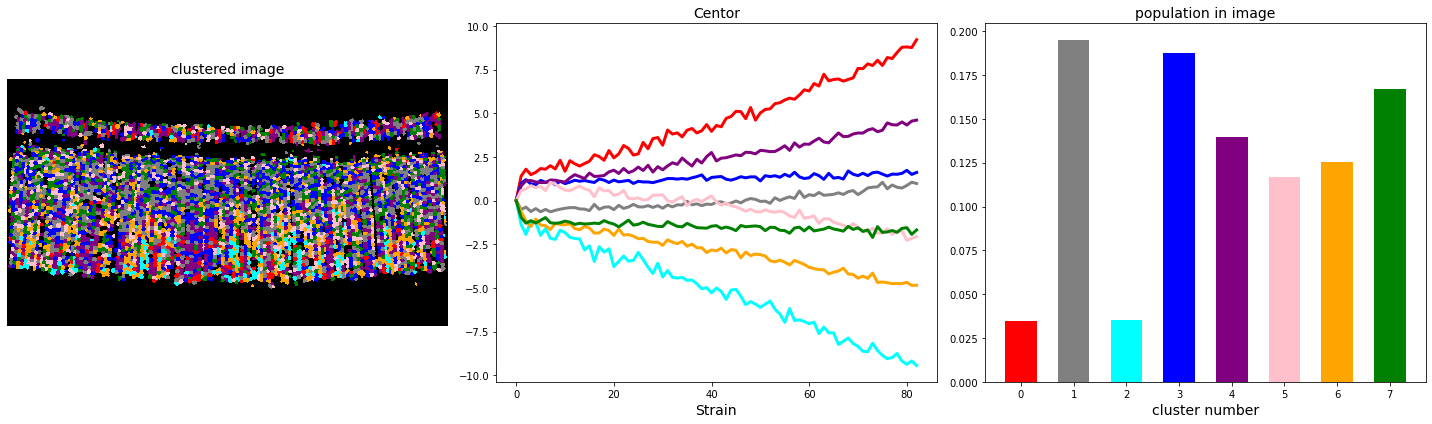

In [48]:
nuclei_true = HF_map['nuclei']
lists_array = HF_list['aspect_axis']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 20,-20, 8)

100%|███████████████████████████████████| 5083/5083 [00:00<00:00, 186267.74it/s]


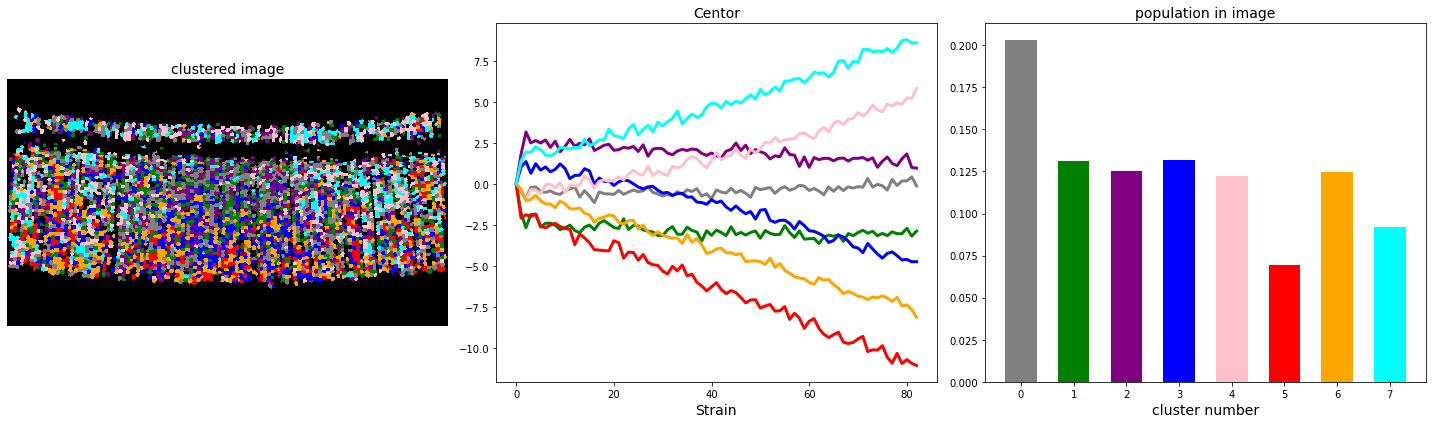

In [49]:
nuclei_true = HF_map['nuclei']
lists_array = HF_list['aspect_bbox']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 20,-20, 8)

100%|███████████████████████████████████| 5083/5083 [00:00<00:00, 188804.78it/s]


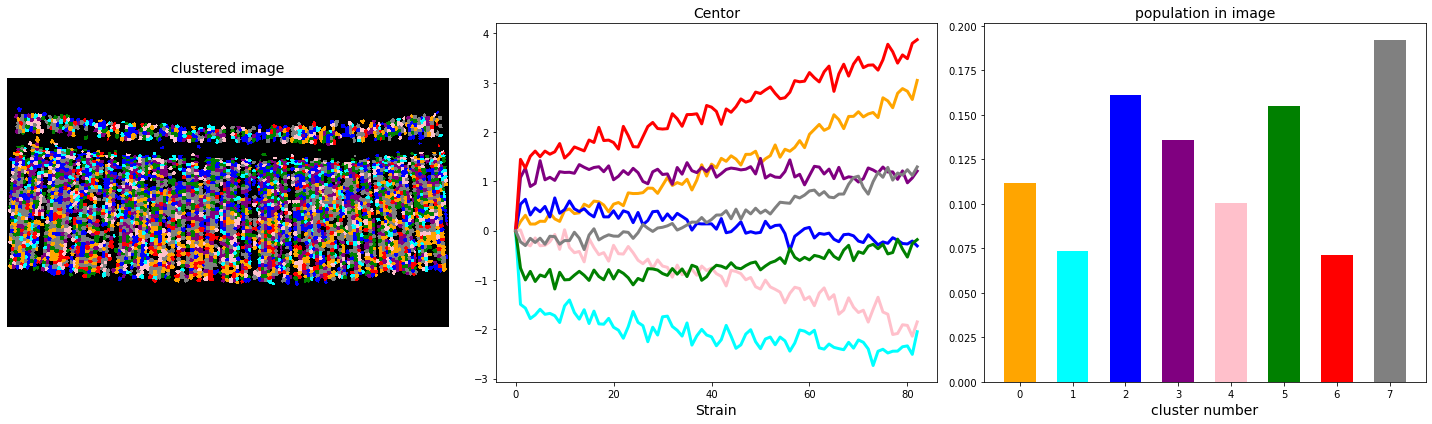

In [50]:
nuclei_true = HF_map['nuclei']
lists_array = HF_list['feret']

kmeans_map_and_distribution(nuclei_true, lists_array, 6, 10,-10, 8)

### q-H-2

In [51]:
# the first frame was not used
HQ_list = np.load('./seg_results/q-H-2_common.npz',allow_pickle=True)
HQ_map = np.load('./seg_results/q-H-2_map_common.npz') 

100%|███████████████████████████████████| 5861/5861 [00:00<00:00, 174893.22it/s]


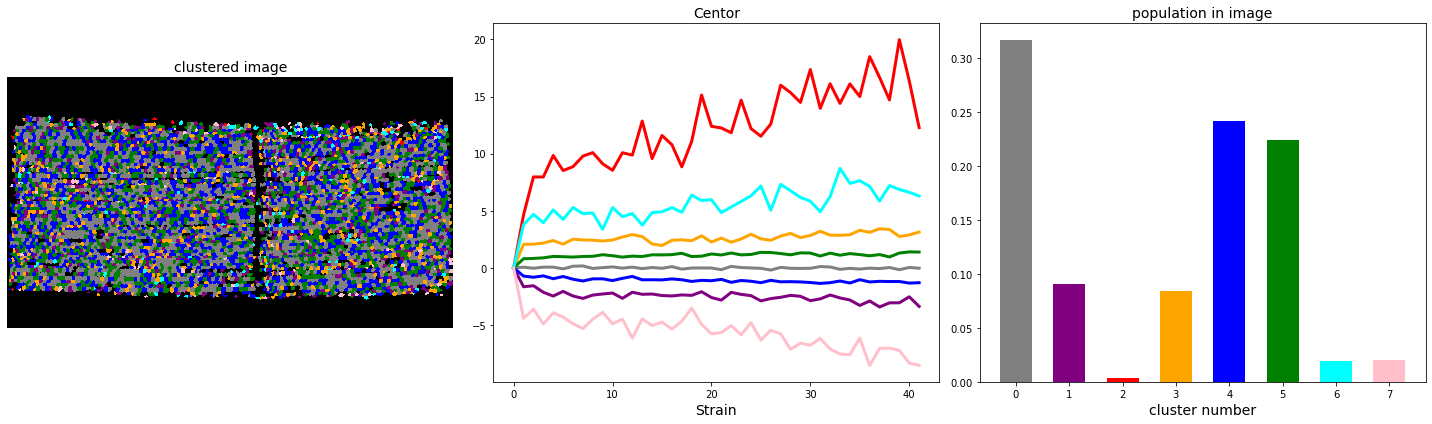

In [53]:
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['area']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 40,-40, 8)

100%|███████████████████████████████████| 5861/5861 [00:00<00:00, 186674.68it/s]


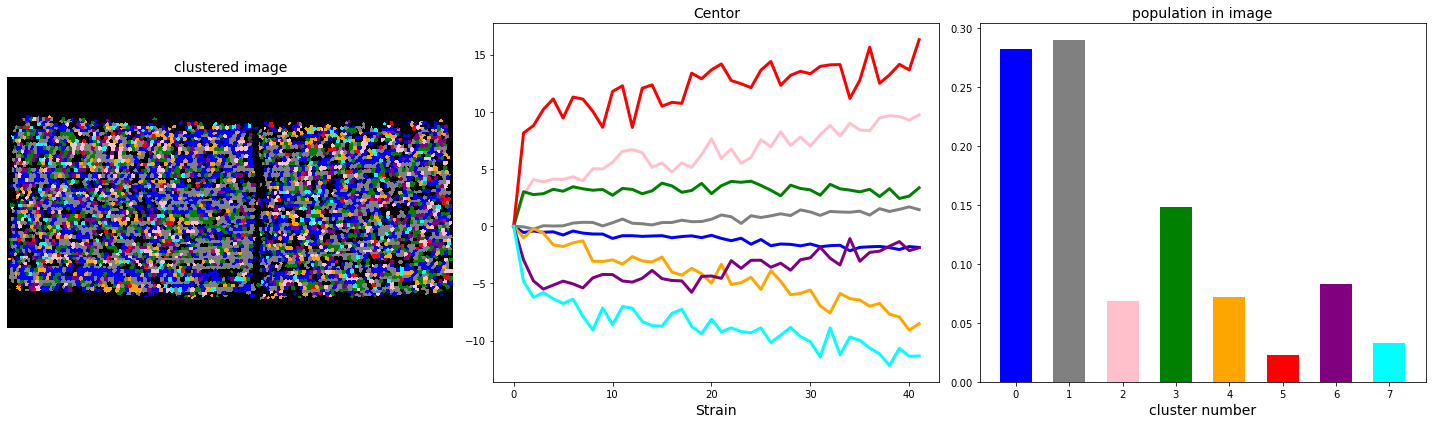

In [54]:
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['ecc']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 40,-40, 8)

100%|███████████████████████████████████| 5861/5861 [00:00<00:00, 185504.08it/s]


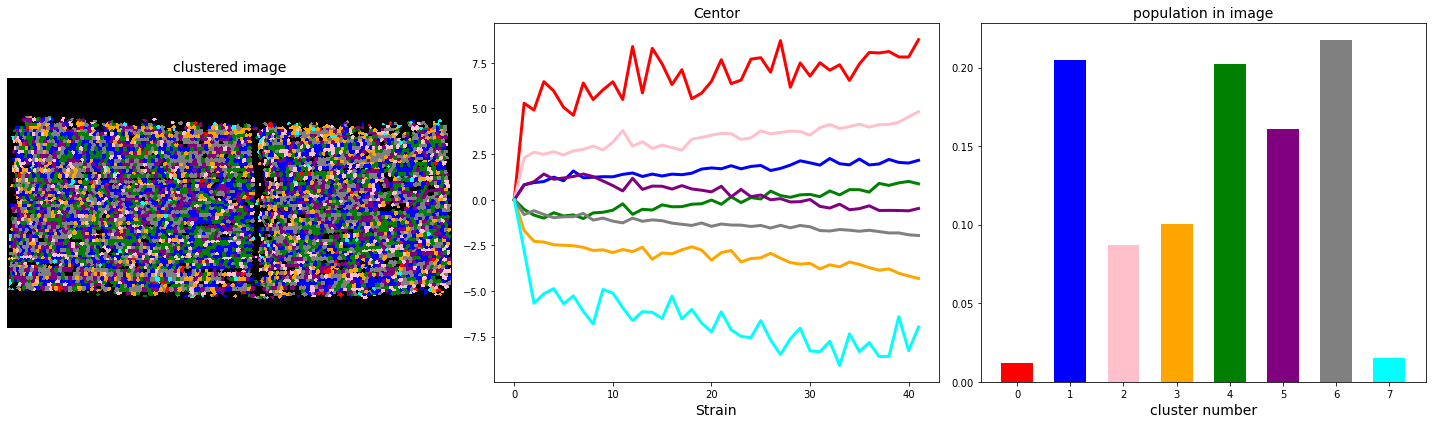

In [55]:
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['aspect_axis']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 40,-40, 8)

100%|███████████████████████████████████| 5861/5861 [00:00<00:00, 180211.39it/s]


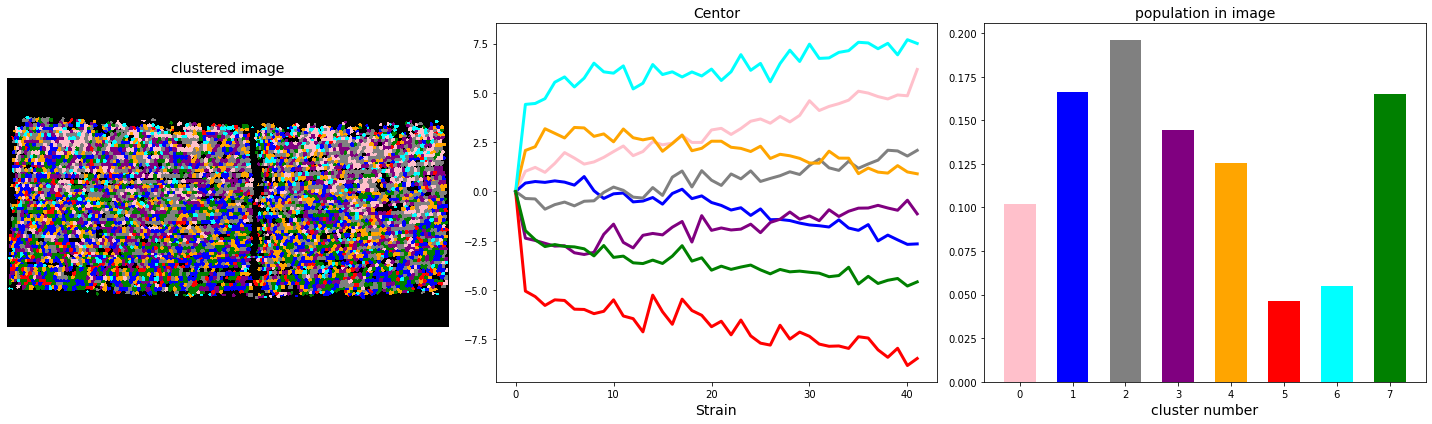

In [56]:
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['aspect_bbox']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 40,-40, 8)

100%|███████████████████████████████████| 5861/5861 [00:00<00:00, 182221.81it/s]


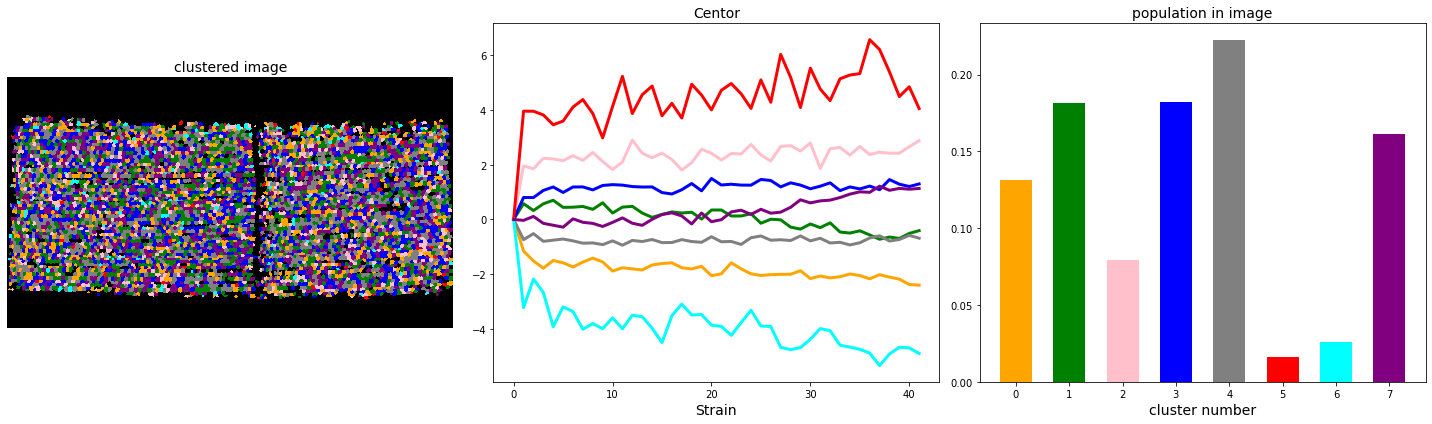

In [57]:
nuclei_true = HQ_map['nuclei']
lists_array = HQ_list['feret']

kmeans_map_and_distribution(nuclei_true, lists_array, 4, 20,-20, 8)